# Imports e leitura do csv

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import io
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
!pip install scikit-plot
import scikitplot as skplt

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

!pip install parameter-sherpa
from sklearn.model_selection import cross_val_score
import time
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization

%matplotlib inline

In [2]:
# Importing libraries used for reading csv from cloud
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
# Cloud authentication and getting file
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1u-Dp_ud44EW814B3WZgWpjt3W-jVdRpc"})
downloaded.GetContentFile('TRNcod.csv')

In [4]:
# Reading csv, dropping INDEX column and peeking at data
df = pd.read_csv('TRNcod.csv')

df = df.drop(columns = ['INDEX'])
print(df.shape)
df.head()

(389196, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.105588,0.796392,-5.140958e-17,0.0,0.1,1.316491e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.000000,0.147356,0.979968,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.500000,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,0.0,1,1,0,0,0,0,0,4.788559e-01,0.083333,0.115789,0.055556,0.147356,0.398645,8.325188e-02,0.2,0.3,4.859488e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.208333,0.000000,0.111111,0.151604,0.398645,-5.140958e-17,0.0,0.5,1.689438e-01,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0


# Mixer de dados

In [5]:
#separando os dados da classe IND_BOM_1_1
dfClass1 = df[df['IND_BOM_1_1']==1]
print(dfClass1.shape)
dfClass1.head()

(255098, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
1,1,0,1,0,0,1,0,0.273504,1,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.000000,0.147356,0.979968,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,0.0,0,0,0,0,0,1,1,5.881235e-18,0.500000,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,0.0,1,1,0,0,0,0,0,4.788559e-01,0.083333,0.115789,0.055556,0.147356,0.398645,8.325188e-02,0.2,0.3,4.859488e-01,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.208333,0.000000,0.111111,0.151604,0.398645,-5.140958e-17,0.0,0.5,1.689438e-01,0.458333,1,1,1,1,0,0,0,0,0,1,0,...,1,0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0
5,0,1,1,0,0,0,1,0.219323,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.147356,0.398645,-5.140958e-17,0.0,0.0,-2.188272e-17,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0


In [6]:
#separando os dados da classe IND_BOM_1_2
dfClass2 = df[df['IND_BOM_1_2']==1]
print(dfClass2.shape)
dfClass2.head()

(134098, 245)


,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,NIVEL_RELACIONAMENTO_CREDITO02,BANCO_REST_IRPF_ULTIMA_1,BANCO_REST_IRPF_ULTIMA_2,BANCO_REST_IRPF_ULTIMA_3,BANCO_REST_IRPF_ULTIMA_4,BANCO_REST_IRPF_ULTIMA_5,BANCO_REST_IRPF_ULTIMA_6,BANCO_REST_IRPF_ULTIMA_7,ATIVIDADE_EMAIL,EXPOSICAO_ENDERECO,EXPOSICAO_EMAIL,EXPOSICAO_TELEFONE,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,EXPOSICAO_CONSUMIDOR_EMAILS,EXPOSICAO_CONSUMIDOR_TELEFONES,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,FLAG_BOLSA_FAMILIA_1,SIGLA_PARTIDO_FILIADO_1,SIGLA_PARTIDO_FILIADO_2,SIGLA_PARTIDO_FILIADO_3,SIGLA_PARTIDO_FILIADO_4,SIGLA_PARTIDO_FILIADO_5,SIGLA_PARTIDO_FILIADO_6,SIGLA_PARTIDO_FILIADO_7,FLAG_FILIADO_PARTIDO_POLITICO_1,FLAG_PROUNI_1,RENDA_VIZINHANCA_1,...,CEP1_3,CEP1_4,CEP1_5,CEP2_1,CEP2_2,CEP2_3,CEP2_4,CEP2_5,CEP2_6,CEP2_7,CEP2_8,CEP2_9,CEP3_1,CEP3_2,CEP3_3,CEP3_4,CEP3_5,CEP3_6,CEP3_7,CEP3_8,CEP3_9,CEP3_10,CEP3_11,CEP3_12,CEP4_1,CEP4_2,CEP4_3,CEP4_4,CEP4_5,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,0.0,0,0,0,0,0,1,1,5.881235e-18,0.041667,0.000000,0.000000,0.105588,0.796392,-5.140958e-17,0.0,0.1,0.131649,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,1,1,0,1
10,1,0,1,1,0,0,0,0.654703,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.333333,0.000000,0.083333,0.147356,0.591956,-5.140958e-17,0.0,0.2,0.085461,0.098958,1,1,1,1,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1,0,1,1,1,1,0,1,0,1,0,0,0,0,0,1
11,1,1,1,0,0,0,0,0.097444,1,0.111111,0.0,0,0,0,0,0,1,1,6.589801e-01,0.027778,0.136842,0.083333,0.151604,0.815862,8.325188e-02,0.6,0.4,0.677012,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1
12,1,0,1,0,1,0,0,0.398961,0,0.111111,0.0,0,0,0,0,0,1,1,5.881235e-18,0.013889,0.000000,0.055556,0.151604,0.850630,-5.140958e-17,0.0,0.3,0.168944,0.000000,0,1,1,1,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,0,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1
17,1,1,1,0,0,0,0,0.142254,0,0.111111,0.0,0,0,0,0,0,1,1,2.162425e-01,125.000000,0.042105,0.111111,0.152312,0.160831,2.817388e-01,0.2,0.5,0.169518,0.000000,0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,1,0,0,1,0,1,0,1,0,1


In [7]:
#porcentagem de cada classe do DF
print(dfClass1.shape[0]/df.shape[0])
print(dfClass2.shape[0]/df.shape[0])

0.6554486685371895
0.34455133146281053


In [8]:
#dividindo o dataframe da classe 1 em 50% treinamento e 50% teste
from sklearn.model_selection import train_test_split
class1_train, class1_test = train_test_split(dfClass1, test_size = 0.5, random_state = 2)

print("class1_train shape: {}".format(class1_train.shape))
print("class1_test shape: {}".format(class1_test.shape))

class1_train shape: (127549, 245)
class1_test shape: (127549, 245)


In [9]:
#dividindo o dataframe de teste da classe 1 em 25% teste e 25% validação
class1_test, class1_validation = train_test_split(class1_test, test_size = 0.5, random_state =2)

print("class1_test shape: {}".format(class1_test.shape))
print("class1_validation shape: {}".format(class1_validation.shape))

class1_test shape: (63774, 245)
class1_validation shape: (63775, 245)


In [10]:
#repetindo as divisões para a classe 2
class2_train, class2_test = train_test_split(dfClass2, test_size = 0.5, random_state = 2)

print("class2_train shape: {}".format(class2_train.shape))
print("class2_test shape: {}".format(class2_test.shape))

class2_train shape: (67049, 245)
class2_test shape: (67049, 245)


In [11]:
class2_test, class2_validation = train_test_split(class2_test, test_size = 0.5, random_state = 2)

In [12]:
print(class2_test.shape)
print(class2_validation.shape)

(33524, 245)
(33525, 245)


In [13]:
#aumentando o dataframe de treinamento da classe minoritária para o dobro do seu tamanho utilizando de repetição
while (class2_train.shape[0] < class1_train.shape[0]):
    class2_train = class2_train.append(class2_train)

print(class2_train.shape)

(134098, 245)


In [14]:
#removendo dados excedentes
class2_train = class2_train.head(class1_train.shape[0])
print(class1_train.shape[0])
print(class2_train.shape[0])

127549
127549


In [15]:
#repetindo o processo para o dataframe de validação
while (class2_validation.shape[0] < class1_validation.shape[0]):
    class2_validation = class2_validation.append(class2_validation)

print(class2_validation.shape)

(67050, 245)


In [16]:
class2_validation = class2_validation.head(class1_validation.shape[0])
print(class1_validation.shape[0])
print(class2_validation.shape[0])

63775
63775


In [17]:
validation_X = class2_validation.append(class1_validation).sample(frac=1)
train_X = class2_train.append(class1_train).sample(frac=1)
test_X = class2_test.append(class1_test).sample(frac=1)

In [18]:
print(validation_X.shape[0])
print(train_X.shape[0])
print(test_X.shape[0])

127550
255098
97298


In [34]:
# Transformando IND_BOM_1_1 e IND_BOM_1_2 (que são mutualmente exclusivos em uma unica medida, BOM)
# BOM = 0 means IND_BOM_1_1 = 1
# BOM = 1 means IND_BOM_1_2 = 1

validation_Y = validation_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
validation_X = validation_X.drop(['IND_BOM_1_1'], axis=1)
validation_X = validation_X.drop(['IND_BOM_1_2'], axis=1)
validation_Y['BOM'] = validation_Y["IND_BOM_1_2"]
validation_Y = validation_Y.drop(['IND_BOM_1_1'], axis=1)
validation_Y = validation_Y.drop(['IND_BOM_1_2'], axis=1)

train_Y = train_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
train_X = train_X.drop(['IND_BOM_1_1'], axis=1)
train_X = train_X.drop(['IND_BOM_1_2'], axis=1)
train_Y['BOM'] = train_Y["IND_BOM_1_2"]
train_Y = train_Y.drop(['IND_BOM_1_1'], axis=1)
train_Y = train_Y.drop(['IND_BOM_1_2'], axis=1)

test_Y = test_X[["IND_BOM_1_1", "IND_BOM_1_2"]]
test_X = test_X.drop(['IND_BOM_1_1'], axis=1)
test_X = test_X.drop(['IND_BOM_1_2'], axis=1)
test_Y['BOM'] = test_Y["IND_BOM_1_2"]
test_Y = test_Y.drop(['IND_BOM_1_1'], axis=1)
test_Y = test_Y.drop(['IND_BOM_1_2'], axis=1)

# exemple:
validation_Y

KeyError: ignored

In [ ]:
# Funções para plotting e etc

def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

## MODELS

Random Forest:

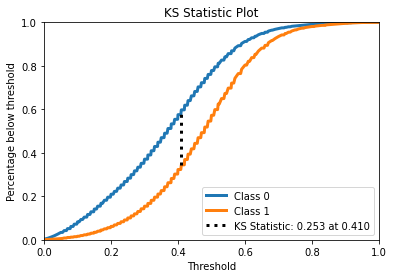


Accuracy:         0.6029
Recall:           0.4274
Precision:        0.6586
F1:               0.5184
AUROC:            0.6704
AUPR:             0.6343


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()  # Modifique aqui os hyperparâmetros
rf_clf.fit(train_X, train_Y)
rf_pred_class = rf_clf.predict(validation_X)
rf_pred_scores = rf_clf.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

SVM:

In [ ]:
#não rodar, não termina
from sklearn.svm import SVC
svc_clf = SVC(probability=True)  # Modifique aqui os hyperparâmetros
svc_clf.fit(train_X, train_Y)
svc_pred_class = svc_clf.predict(validation_X)
svc_pred_scores = svc_clf.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, svc_pred_class, svc_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

GradientBoosting:

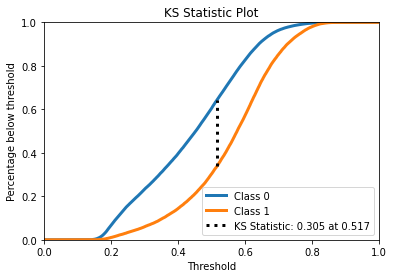


Accuracy:         0.6509
Recall:           0.6975
Precision:        0.6380
F1:               0.6664
AUROC:            0.7091
AUPR:             0.6922


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()  # Modifique aqui os hyperparâmetros
gb_clf.fit(train_X, train_Y)
gb_pred_class = gb_clf.predict(validation_X)
gb_pred_scores = gb_clf.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

In [24]:
input_dim = train_X.shape[1]

In [25]:
# Model basico
def create_sklearn_compatible_model():
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='softmax'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Tuning do model de duas camadas com SGD
def create_sklearn_compatible_model_1():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com SGD
def create_sklearn_compatible_model_2():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.SGD(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de duas camadas com ADAM
def create_sklearn_compatible_model_3():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'], 
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

# Tuning do model de uma camadas com ADAM
def create_sklearn_compatible_model_4():
    model = Sequential()
    model.add(Dense(trial.parameters['hidden_layer_sizes'], 
                    activation=trial.parameters['activation'],
                    input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model

In [ ]:
# Para modelo basico
from keras.wrappers.scikit_learn import KerasClassifier
mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=1)
mlp_clf.fit(train_X, train_Y)
mlp_pred_class = mlp_clf.predict(validation_X)
mlp_pred_scores = mlp_clf.predict_proba(validation_X)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

MLP Tuning com Sherpa

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

parameters = [sherpa.Choice('hidden_layer_sizes', [32,64,128,256]),
              sherpa.Choice('activation', ['tanh', 'relu']),
              sherpa.Continuous('learning_rate', [0.00001, 0.001])]

algorithm = bayesian_optimization.GPyOpt(max_concurrent=1,model_type='GP_MCMC',acquisition_type='EI_MCMC',max_num_trials=10)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trial  1  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.00014897075191333596}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2460
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2393
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2378
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2367
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2360
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2350
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2345
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2339
Epoch 9/100
3986/3986 [==============================] - 9s 2ms/step - 

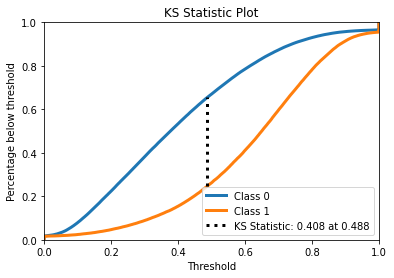

Performance no conjunto de treino:

Accuracy:         0.7039
Recall:           0.7380
Precision:        0.6909
F1:               0.7137
AUROC:            0.7525
AUPR:             0.6950


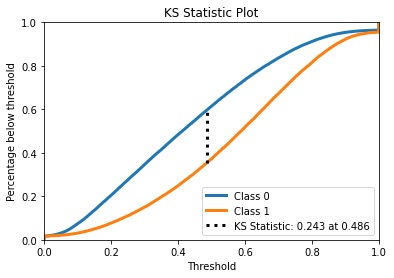

Performance no conjunto de validação:

Accuracy:         0.6213
Recall:           0.6279
Precision:        0.6197
F1:               0.6238
AUROC:            0.6581
AUPR:             0.6177
Trial  2  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.000231328992684637}
Epoch 1/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2345
Epoch 2/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2284
Epoch 3/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2273
Epoch 4/100
3986/3986 [==============================] - 6s 1ms/step - loss: 0.2262
Epoch 5/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2253
Epoch 6/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2245
Epoch 7/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2238
Epoch 8/100
3986/3986 [==============================] - 6s 2ms/step - loss: 0.2231
Epoch 9/100
3986/3986 [=

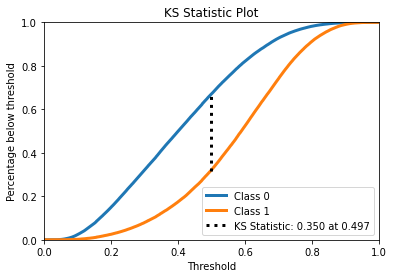

Performance no conjunto de treino:

Accuracy:         0.6748
Recall:           0.6786
Precision:        0.6735
F1:               0.6760
AUROC:            0.7351
AUPR:             0.7127


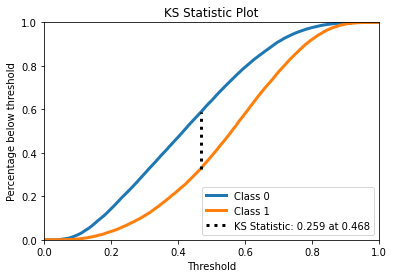

Performance no conjunto de validação:

Accuracy:         0.6278
Recall:           0.6156
Precision:        0.6310
F1:               0.6232
AUROC:            0.6776
AUPR:             0.6561
Trial  3  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0008376007820079858}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2267
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2249
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2234
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2222
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2212
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2202
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2191
Epoch 9/100
3986/3986 

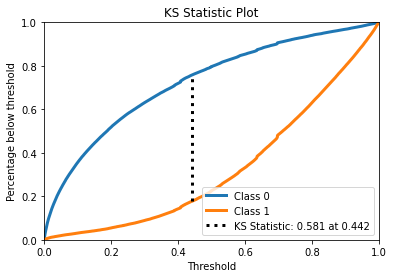

Performance no conjunto de treino:

Accuracy:         0.7854
Recall:           0.7743
Precision:        0.7919
F1:               0.7830
AUROC:            0.8523
AUPR:             0.8168


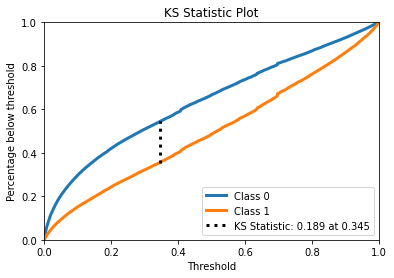

Performance no conjunto de validação:

Accuracy:         0.5904
Recall:           0.5141
Precision:        0.6066
F1:               0.5566
AUROC:            0.6291
AUPR:             0.6085
Trial  4  with parameters  {'hidden_layer_sizes': 128, 'activation': 'tanh', 'learning_rate': 0.0004090311213853634}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2276
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2257
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2243
Epoch 5/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2231
Epoch 6/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2222
Epoch 7/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2214
Epoch 8/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2206
Epoch 9/100
3986/3

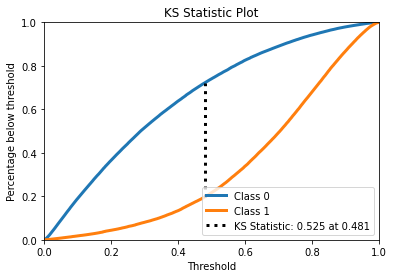

Performance no conjunto de treino:

Accuracy:         0.7618
Recall:           0.7834
Precision:        0.7510
F1:               0.7668
AUROC:            0.8259
AUPR:             0.7946


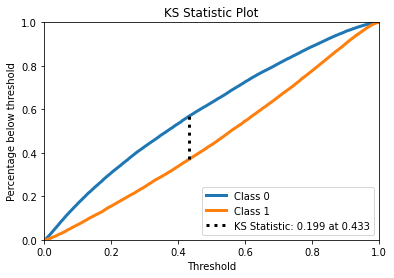

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.5970
Recall:           0.5634
Precision:        0.6040
F1:               0.5830
AUROC:            0.6360
AUPR:             0.6168
Trial  5  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2586
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2448
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2391
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2361
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2344
Epoch 6/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2332
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2323
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2316
Epoch 9/100
3986/3986 [================

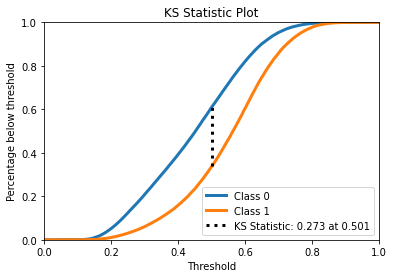

Performance no conjunto de treino:

Accuracy:         0.6362
Recall:           0.6638
Precision:        0.6290
F1:               0.6460
AUROC:            0.6858
AUPR:             0.6649


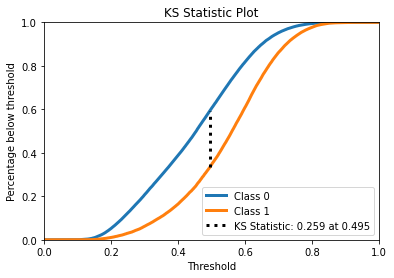

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6295
Recall:           0.6549
Precision:        0.6232
F1:               0.6387
AUROC:            0.6790
AUPR:             0.6582
Trial  6  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1.5242317551969889e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2605
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2495
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2450
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2420
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2401
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2386
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2376
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2368
Epoch 9/100
3986/3986 

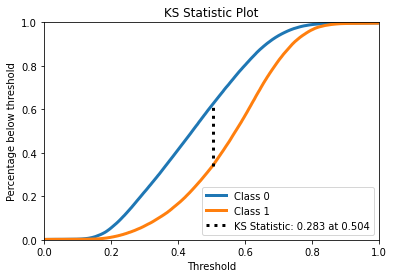

Performance no conjunto de treino:

Accuracy:         0.6412
Recall:           0.6664
Precision:        0.6345
F1:               0.6501
AUROC:            0.6907
AUPR:             0.6629


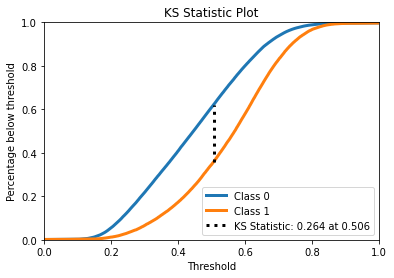

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6316
Recall:           0.6545
Precision:        0.6258
F1:               0.6398
AUROC:            0.6816
AUPR:             0.6545
Trial  7  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 0.001}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2468
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2402
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2370
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2337
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2309
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2302
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2286
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2280
Epoch 9/100
3986/3986 [================

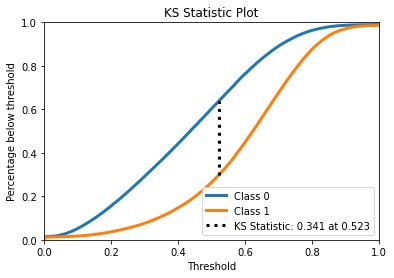

Performance no conjunto de treino:

Accuracy:         0.6696
Recall:           0.7363
Precision:        0.6497
F1:               0.6903
AUROC:            0.7232
AUPR:             0.6862


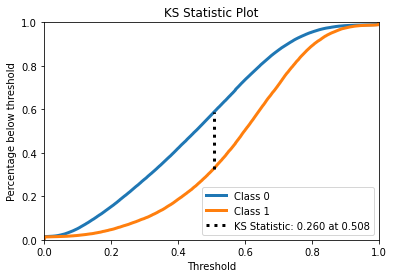

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6294
Recall:           0.6837
Precision:        0.6167
F1:               0.6484
AUROC:            0.6724
AUPR:             0.6366
Trial  8  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2700
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2584
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2532
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2454
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2398
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2381
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2367
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2355
Epoch 9/100
3986/3986 [================

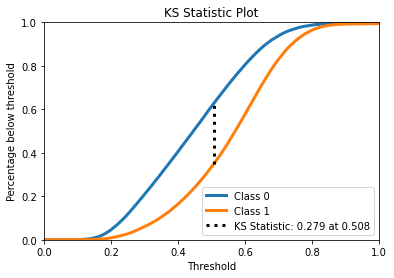

Performance no conjunto de treino:

Accuracy:         0.6392
Recall:           0.6654
Precision:        0.6323
F1:               0.6484
AUROC:            0.6880
AUPR:             0.6571


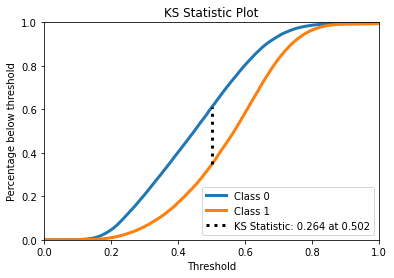

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6319
Recall:           0.6552
Precision:        0.6260
F1:               0.6403
AUROC:            0.6810
AUPR:             0.6510
Trial  9  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2745
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2651
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2542
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2510
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2488
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2474
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2461
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2448
Epoch 9/100
3986/3986 [================

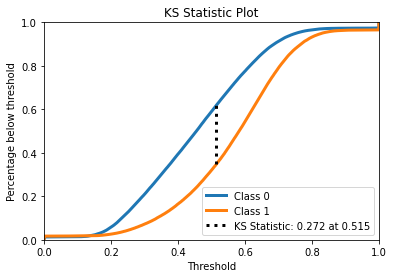

Performance no conjunto de treino:

Accuracy:         0.6349
Recall:           0.6800
Precision:        0.6238
F1:               0.6507
AUROC:            0.6768
AUPR:             0.6383


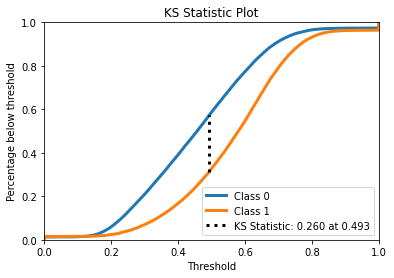

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6297
Recall:           0.6729
Precision:        0.6193
F1:               0.6450
AUROC:            0.6727
AUPR:             0.6348
Trial  10  with parameters  {'hidden_layer_sizes': 32, 'activation': 'relu', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2690
Epoch 2/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2581
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2505
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2439
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2413
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2395
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2379
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2366
Epoch 9/100
3986/3986 [===============

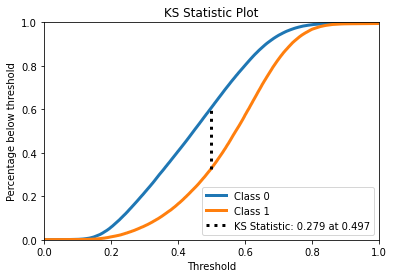

Performance no conjunto de treino:

Accuracy:         0.6397
Recall:           0.6708
Precision:        0.6315
F1:               0.6506
AUROC:            0.6886
AUPR:             0.6594


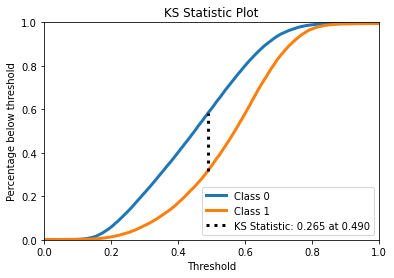

Performance no conjunto de validação:

Accuracy:         0.6320
Recall:           0.6611
Precision:        0.6248
F1:               0.6424
AUROC:            0.6808
AUPR:             0.6516
{'Trial-ID': 10, 'Iteration': 1, 'activation': 'relu', 'hidden_layer_sizes': 32, 'learning_rate': 1e-05, 'Objective': 0.6320109760878087}


In [ ]:
## 1 LAYER - ADAM
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_4, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://172.28.0.2:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Trial  1  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.0008709631800860401}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2305
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2259
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2242
Epoch 4/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2229
Epoch 5/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2219
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2211
Epoch 7/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2203
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2195
Epoch 9/100
3986/3986 [==============================] - 8s 2ms/step - lo

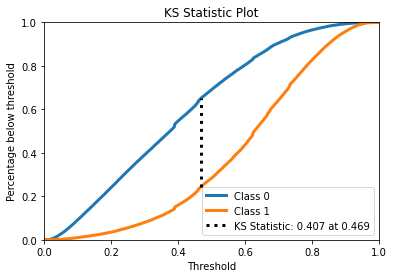

Performance no conjunto de treino:

Accuracy:         0.7035
Recall:           0.7171
Precision:        0.6981
F1:               0.7075
AUROC:            0.7690
AUPR:             0.7433


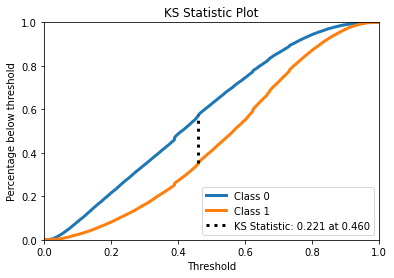

Performance no conjunto de validação:

Accuracy:         0.6080
Recall:           0.5916
Precision:        0.6116
F1:               0.6015
AUROC:            0.6496
AUPR:             0.6263
Trial  2  with parameters  {'hidden_layer_sizes': 32, 'activation': 'tanh', 'learning_rate': 0.0008124009189887667}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2312
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2263
Epoch 3/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2244
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2231
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2219
Epoch 6/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2210
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2202
Epoch 8/100
3986/3986 [==============================] - 7s 2ms/step - loss: 0.2197
Epoch 9/100
3986/3986 [

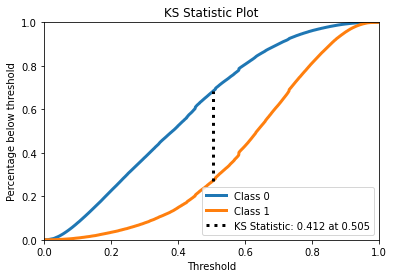

Performance no conjunto de treino:

Accuracy:         0.7058
Recall:           0.7344
Precision:        0.6946
F1:               0.7140
AUROC:            0.7707
AUPR:             0.7459


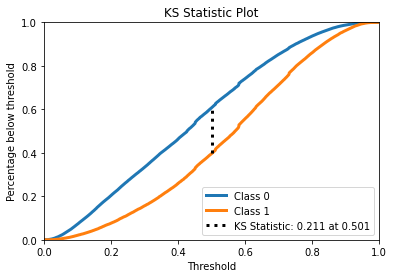

Performance no conjunto de validação:

Accuracy:         0.6055
Recall:           0.6043
Precision:        0.6058
F1:               0.6050
AUROC:            0.6465
AUPR:             0.6247
Trial  3  with parameters  {'hidden_layer_sizes': 128, 'activation': 'relu', 'learning_rate': 0.0007845871713611148}
Epoch 1/100
3986/3986 [==============================] - 12s 3ms/step - loss: 0.2532
Epoch 2/100
3986/3986 [==============================] - 10s 3ms/step - loss: 0.2409
Epoch 3/100
3986/3986 [==============================] - 12s 3ms/step - loss: 0.2347
Epoch 4/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2312
Epoch 5/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2284
Epoch 6/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2254
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2198
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2185
Epoch 9/100
3986

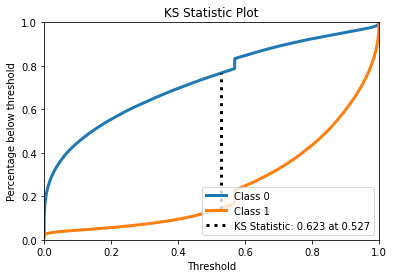

Performance no conjunto de treino:

Accuracy:         0.8107
Recall:           0.8693
Precision:        0.7781
F1:               0.8212
AUROC:            0.8707
AUPR:             0.8400


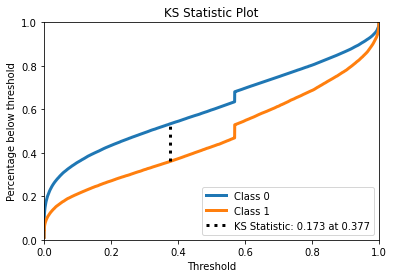

Performance no conjunto de validação:

Accuracy:         0.5849
Recall:           0.5724
Precision:        0.5870
F1:               0.5796
AUROC:            0.6112
AUPR:             0.5854
Trial  4  with parameters  {'hidden_layer_sizes': 64, 'activation': 'relu', 'learning_rate': 0.0005520184306063196}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2441
Epoch 2/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2337
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2310
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2289
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2263
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2232
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2211
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2204
Epoch 9/100
3986/3986 [

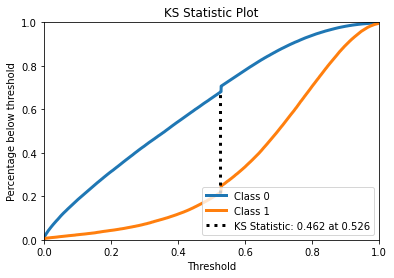

Performance no conjunto de treino:

Accuracy:         0.7297
Recall:           0.8080
Precision:        0.6985
F1:               0.7493
AUROC:            0.7975
AUPR:             0.7655


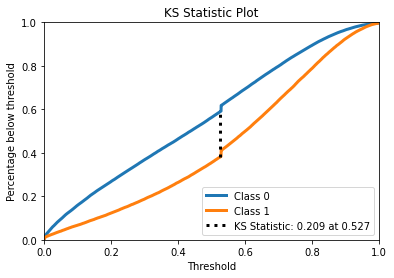

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6038
Recall:           0.6453
Precision:        0.5959
F1:               0.6196
AUROC:            0.6397
AUPR:             0.6132
Trial  5  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2453
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2367
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2338
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2322
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2311
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2303
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2297
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2293
Epoch 9/100
3986/3986 [================

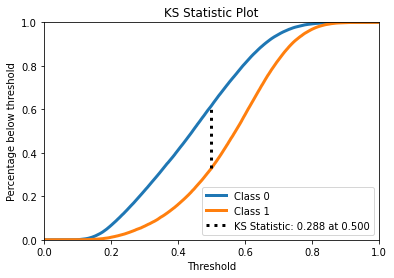

Performance no conjunto de treino:

Accuracy:         0.6441
Recall:           0.6711
Precision:        0.6367
F1:               0.6534
AUROC:            0.6962
AUPR:             0.6753


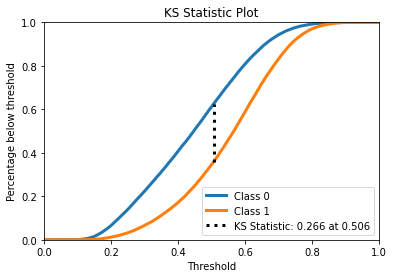

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6540
Precision:        0.6273
F1:               0.6404
AUROC:            0.6841
AUPR:             0.6624
Trial  6  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 0.001}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2305
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2259
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2241
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2228
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2215
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2203
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2194
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2180
Epoch 9/100
3986/3986 [================

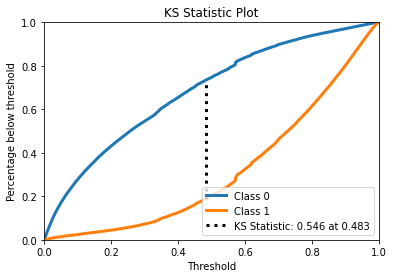

Performance no conjunto de treino:

Accuracy:         0.7726
Recall:           0.7979
Precision:        0.7595
F1:               0.7782
AUROC:            0.8426
AUPR:             0.8131


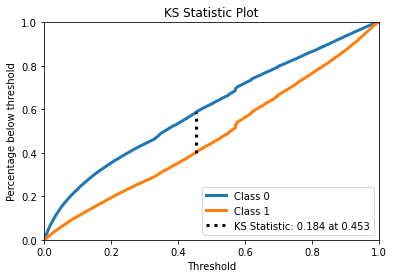

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.5903
Recall:           0.5557
Precision:        0.5970
F1:               0.5756
AUROC:            0.6252
AUPR:             0.6031
Trial  7  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 10s 2ms/step - loss: 0.2482
Epoch 2/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2378
Epoch 3/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2343
Epoch 4/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2325
Epoch 5/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 10s 2ms/step - loss: 0.2304
Epoch 7/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2298
Epoch 8/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2292
Epoch 9/100
3986/3986 [==============

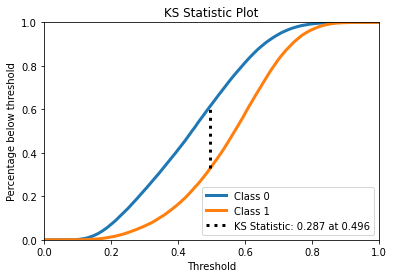

Performance no conjunto de treino:

Accuracy:         0.6430
Recall:           0.6638
Precision:        0.6373
F1:               0.6503
AUROC:            0.6961
AUPR:             0.6754


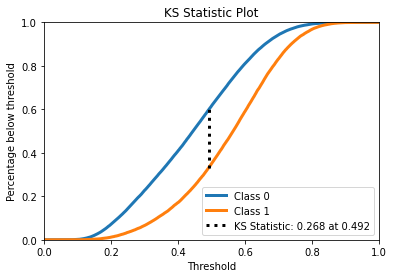

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6501
Precision:        0.6284
F1:               0.6390
AUROC:            0.6850
AUPR:             0.6639
Trial  8  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2466
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2371
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2340
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2324
Epoch 5/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2305
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2299
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2294
Epoch 9/100
3986/3986 [================

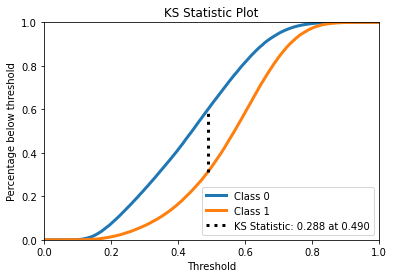

Performance no conjunto de treino:

Accuracy:         0.6437
Recall:           0.6654
Precision:        0.6377
F1:               0.6513
AUROC:            0.6955
AUPR:             0.6746


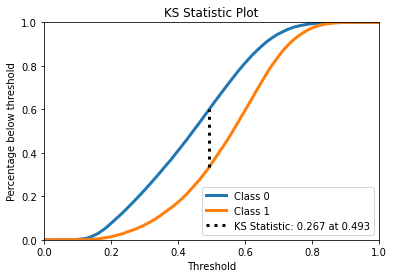

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6323
Recall:           0.6497
Precision:        0.6278
F1:               0.6386
AUROC:            0.6838
AUPR:             0.6632
Trial  9  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 11s 3ms/step - loss: 0.2471
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2368
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2336
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2319
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2309
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2302
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2297
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2292
Epoch 9/100
3986/3986 [===============

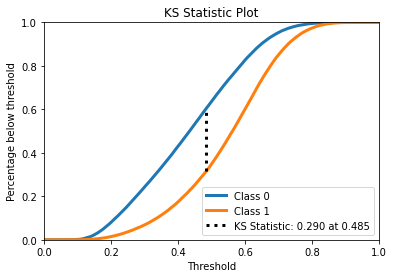

Performance no conjunto de treino:

Accuracy:         0.6442
Recall:           0.6522
Precision:        0.6419
F1:               0.6470
AUROC:            0.6958
AUPR:             0.6746


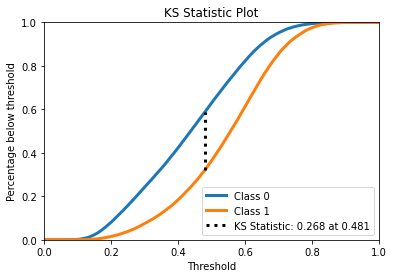

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6367
Precision:        0.6318
F1:               0.6342
AUROC:            0.6837
AUPR:             0.6629
Trial  10  with parameters  {'hidden_layer_sizes': 64, 'activation': 'tanh', 'learning_rate': 1e-05}
Epoch 1/100
3986/3986 [==============================] - 9s 2ms/step - loss: 0.2486
Epoch 2/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2380
Epoch 3/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2343
Epoch 4/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2325
Epoch 5/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2313
Epoch 6/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2305
Epoch 7/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2299
Epoch 8/100
3986/3986 [==============================] - 8s 2ms/step - loss: 0.2294
Epoch 9/100
3986/3986 [===============

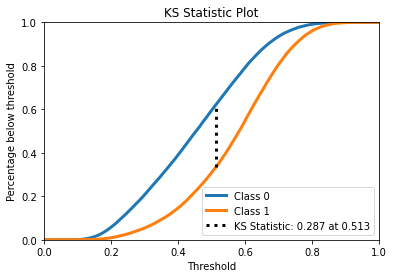

Performance no conjunto de treino:

Accuracy:         0.6431
Recall:           0.6915
Precision:        0.6304
F1:               0.6596
AUROC:            0.6960
AUPR:             0.6746


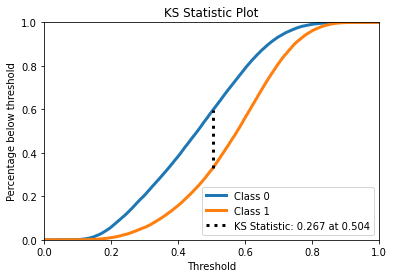

Performance no conjunto de validação:

Accuracy:         0.6328
Recall:           0.6781
Precision:        0.6218
F1:               0.6487
AUROC:            0.6838
AUPR:             0.6641
{'Trial-ID': 9, 'Iteration': 1, 'activation': 'tanh', 'hidden_layer_sizes': 64, 'learning_rate': 1e-05, 'Objective': 0.6328185025480204}


In [33]:
## 2 LAYERS - ADAM
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_3, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

In [ ]:
## 1 LAYERS - SGD
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_2, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

In [ ]:
## 2 LAYERS - SGD
study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model_1, 
                          batch_size=64, epochs=100)
    mlp_clf.fit(train_X, train_Y)
    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    study.add_observation(trial,
                          iteration=1,
                          objective=accuracy)
    study.finalize(trial)
print(study.get_best_result())

In [ ]:
# parameter_space = {
#     'hidden_layer_sizes': [32,64,128,256],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }

# Weight Regularization for Dense Layers:
# model.add(Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# model.add(Dense(500, input_dim=2, activation='relu', kernel_regularizer=l2(param)))


# model_A.add(BatchNormalization())
# model_K.add(Dropout(0.5))

In [ ]:
# 1 LAYER WITH CROSS VALIDATION - ignore for now



study = sherpa.Study(parameters=parameters,
                     algorithm=algorithm,
                     lower_is_better=False)

for trial in study:
    print("Trial ", trial.id, " with parameters ", trial.parameters)
    mlp_clf = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100)
    scores = cross_val_score(mlp_clf, train_X, train_Y, cv=5)

    mlp_pred_class = mlp_clf.predict(train_X)
    mlp_pred_scores = mlp_clf.predict_proba(train_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(train_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de treino:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    mlp_pred_class = mlp_clf.predict(validation_X)
    mlp_pred_scores = mlp_clf.predict_proba(validation_X)
    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(validation_Y, mlp_pred_class, mlp_pred_scores)
    print('Performance no conjunto de validação:')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)




    study.add_observation(trial, iteration=1, objective=scores.mean())
    study.finalize(trial)
print(study.get_best_result())